In [1]:
import sys
sys.path.append('..')

In [2]:
import re
from datetime import datetime, timedelta
from pathlib import Path
from typing import Optional

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

from myutils.matplotlib import matplotlib_seaborn_style

from src.missing_values import impute_average

matplotlib_seaborn_style()

In [3]:
results_dir = Path('../data/preprocessing')
results_dir.mkdir(exist_ok=True)

figures_dir = results_dir / 'figures'
figures_dir.mkdir(exist_ok=True)

## Базовая реструктуризация данных

## Препроцессинг

In [4]:
data = pd.read_csv('../data/raw_data/data.csv', parse_dates=['date'], encoding='utf-8')

data.head(2)

,date,days,places,price,num,class,train
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе


In [5]:
data['train'].nunique()

144

### Добавляем данные о поездах

In [6]:
train_timetable = pd.read_csv('../data/train_timetable.csv')

train_timetable.head(2)

,num,departure_time,travel_time
0,701Н,07:45,03:52
1,703Н,11:05,03:55


In [7]:
def to_hour(time: str) -> int:
    hour, minute = time.split(':')
    hour = int(hour)
    minute = int(minute)
    
    # timestamp = (hour * 60 + minute) * 60
    hour = hour + minute / 60
        
    return hour


train_timetable['departure_hour'] = train_timetable['departure_time'].apply(to_hour)
train_timetable['arrival_hour'] = (train_timetable['departure_hour'] \
    + train_timetable['travel_time'].apply(to_hour)) % 24

train_timetable.head(2)

,num,departure_time,travel_time,departure_hour,arrival_hour
0,701Н,07:45,03:52,7.750000,11.616667
1,703Н,11:05,03:55,11.083333,15.000000


In [8]:
data = data.merge(
    train_timetable[['num', 'departure_hour', 'arrival_hour']],
    on='num',
    how='left',
)

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе,23.916667,7.916667
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе,23.916667,7.916667


In [9]:
data.loc[data['departure_hour'].isna(), 'num'].unique()

array([], dtype=object)

### Удаляем данные за праздники (29 апреля — 12 мая)

In [10]:
holidays = np.arange(
    datetime(year=2021, month=4, day=29),
    datetime(year=2021, month=5, day=13),
    timedelta(days=1),
)

data = data[~data['date'].isin(holidays)].copy()

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе,23.916667,7.916667
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе,23.916667,7.916667


### Заполненность строк для разных поездов

In [11]:
dates = data['date'].drop_duplicates().sort_values().values

split_id = np.where(dates > holidays[-1])[0][0]

In [12]:
def date_formatter(dt: datetime) -> str:
    return dt.strftime('%b %d (%a)')

In [13]:
filled_frac = pd.DataFrame({
    train: data[(data['train'] == train) & (data['days'] <= 30)]\
                    .pivot(index='date', columns='days', values='places')\
                    .notna().mean(axis=1)
    for train in sorted(data['train'].unique())
}).reindex(dates).fillna(0)

filled_frac.head(2)

,001А-Купе,001А-СВ,002А-Купе,002А-СВ,003А-Купе,003А-СВ,004А-Купе,004А-СВ,005А-Купе,005А-СВ,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-04-03,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,...,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2021-04-04,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,...,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667


/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/_backend_pdf_ps.py:102: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib

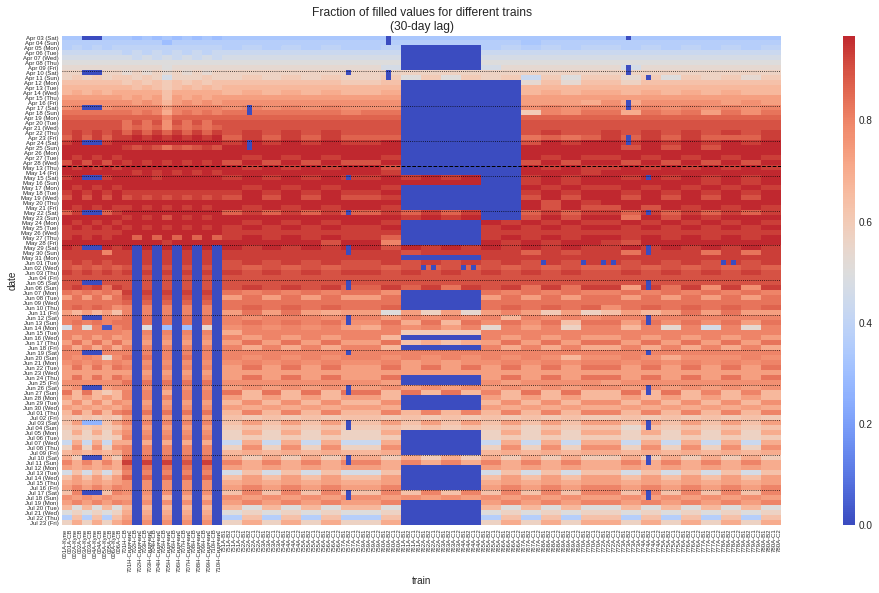

In [14]:
filled_frac_ = filled_frac.copy()
filled_frac_.index = filled_frac_.index.map(date_formatter)

ax = plt.figure(figsize=(22, 9)).gca()
sns.heatmap(filled_frac_, center=0.5, square=True, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Fraction of filled values for different trains\n'
             '(30-day lag)')

plt.savefig(figures_dir / 'filled_frac.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Удаляем поезда, по которым слишком мало данных

__Важно!__ Надо не забыть, что мы не просто выкидываем данные, а планируем рассмотреть их отдельно, когда данных станет больше.

In [15]:
train_nums_to_remove = ['761А', '762А', '763А', '764А', '765А', '766А', '702Н', '704Н', '706Н', '708Н', '710Н']

mask = data['num'].isin(train_nums_to_remove)
data = data[~mask].copy()

mask.sum(), data['train'].nunique()

(78026, 110)

In [16]:
filled_frac_melt = filled_frac.reset_index()\
    .melt(id_vars='date', var_name='train', value_name='filled_frac')

filled_frac_melt.head(2)

,date,train,filled_frac
0,2021-04-03,001А-Купе,0.333333
1,2021-04-04,001А-Купе,0.366667


In [17]:
to_remove = filled_frac_melt.loc[filled_frac_melt['filled_frac'] <= 0.6, ['train', 'date']]\
    .groupby('train')['date'].apply(lambda s: s.unique())

print(to_remove.apply(len).sum())

to_remove.head(2)

3962


train
001А-Купе    [2021-04-03T00:00:00.000000000, 2021-04-04T00:...
001А-СВ      [2021-04-03T00:00:00.000000000, 2021-04-04T00:...
Name: date, dtype: object

In [18]:
for train, dates_to_remove in tqdm(to_remove.iteritems(), total=len(to_remove)):
    mask = ((data['train'] == train) & data['date'].isin(dates_to_remove))
    data = data[~mask].copy()

data['train'].nunique()

  0%|          | 0/144 [00:00<?, ?it/s]

110

/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/_backend_pdf_ps.py:102: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib

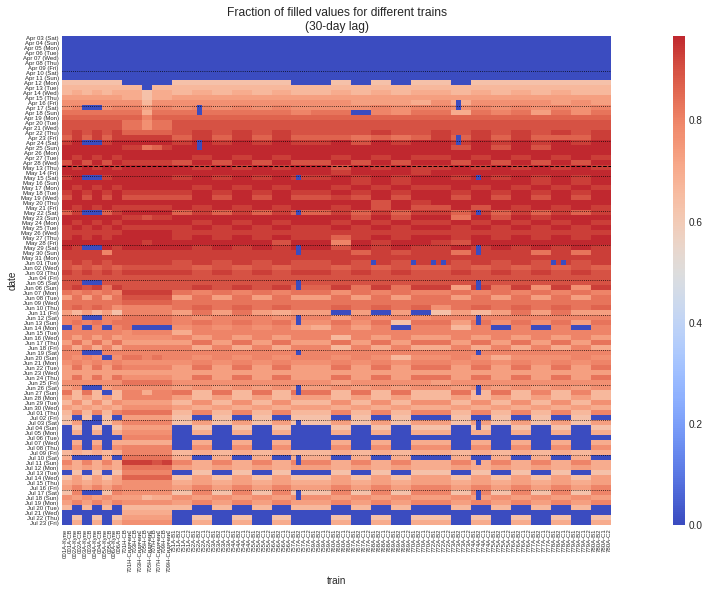

In [19]:
filled_frac = pd.DataFrame({
    train: data[(data['train'] == train) & (data['days'] <= 30)]\
                    .pivot(index='date', columns='days', values='places')\
                    .notna().mean(axis=1)
    for train in sorted(data['train'].unique())
}).reindex(dates).fillna(0)
filled_frac.index = filled_frac.index.map(date_formatter)

ax = plt.figure(figsize=(22, 9)).gca()
sns.heatmap(filled_frac, center=0.5, square=True, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Fraction of filled values for different trains\n'
             '(30-day lag)')

plt.savefig(figures_dir / 'filled_frac_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Вместимость каждого поезда в зависимости от даты

In [20]:
capacity = data.groupby(['train', 'date'])['places'].max().reset_index()\
    .pivot(index='date', columns='train', values='places')\
    .reindex(dates).fillna(0)
capacity /= capacity.max()

capacity.head(2)

train,001А-Купе,001А-СВ,002А-Купе,002А-СВ,003А-Купе,003А-СВ,004А-Купе,004А-СВ,005А-Купе,005А-СВ,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/_backend_pdf_ps.py:102: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib

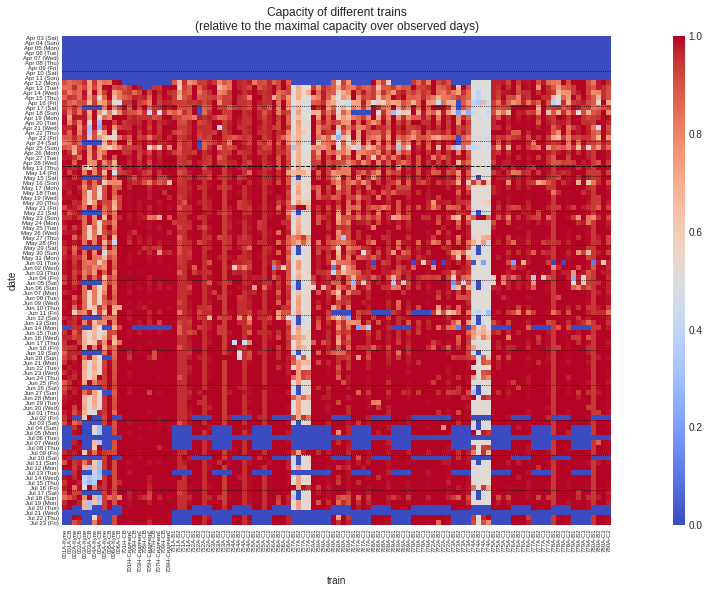

In [21]:
capacity_ = capacity.copy()
capacity_.index = capacity_.index.map(date_formatter)

ax = plt.figure(figsize=(22, 9)).gca()
sns.heatmap(capacity_, ax=ax, square=True, center=0.5, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, capacity_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Capacity of different trains\n'
             '(relative to the maximal capacity over observed days)')

plt.savefig(figures_dir / 'capacity.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Удаляем для некоторых поездов даты, в которые количество вагонов существенно отличается

Белые пятна на картинке выше свидетельствуют о том, что в отдельные дни администрацией РЖД меняется количество вагонов у поезда. Такого рода ситуации надо обрабатывать отдельно. Пока что просто выкидываем.

In [22]:
train_nums_to_remove = ['003А', '004А', '757А', '774А']

mask = data['num'].isin(train_nums_to_remove)

data = data[~mask].copy()

mask.sum()

50887

In [23]:
capacity_melt = capacity.reset_index()\
    .melt(id_vars='date', var_name='train', value_name='capacity')

capacity_melt.head(2)

,date,train,capacity
0,2021-04-03,001А-Купе,0.0
1,2021-04-04,001А-Купе,0.0


In [24]:
to_remove = capacity_melt.loc[capacity_melt['capacity'] <= 0.7, ['train', 'date']]\
    .groupby('train')['date'].apply(lambda s: s.unique())

print(to_remove.apply(len).sum())

to_remove.head(2)

2651


train
001А-Купе    [2021-04-03T00:00:00.000000000, 2021-04-04T00:...
001А-СВ      [2021-04-03T00:00:00.000000000, 2021-04-04T00:...
Name: date, dtype: object

In [25]:
for train, dates_to_remove in tqdm(to_remove.iteritems(), total=len(to_remove)):
    mask = ((data['train'] == train) & data['date'].isin(dates_to_remove))
    data = data[~mask].copy()

data['train'].nunique()

  0%|          | 0/110 [00:00<?, ?it/s]

98

/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/_backend_pdf_ps.py:102: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib

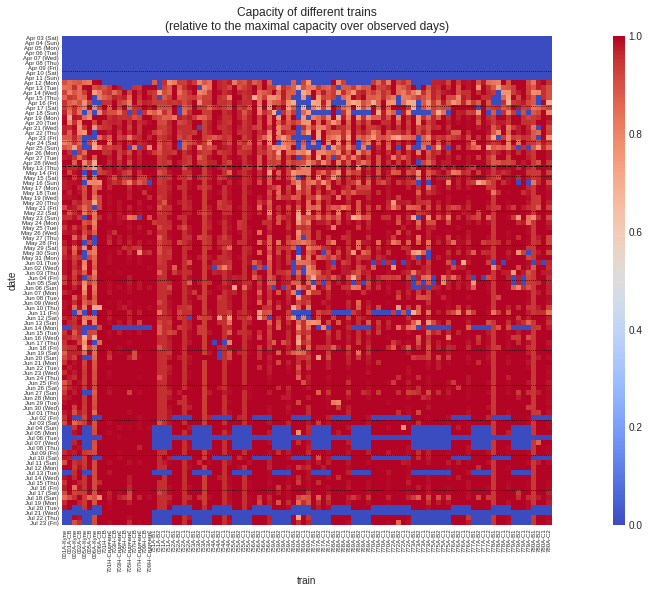

In [26]:
capacity_ = data.groupby(['train', 'date'])['places'].max().reset_index()\
    .pivot(index='date', columns='train', values='places')\
    .reindex(dates).fillna(0)
capacity_ /= capacity_.max()
capacity_.index = capacity_.index.map(date_formatter)

ax = plt.figure(figsize=(22, 9)).gca()
sns.heatmap(capacity_, ax=ax, square=True, center=0.5, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, capacity_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Capacity of different trains\n'
             '(relative to the maximal capacity over observed days)')

plt.savefig(figures_dir / 'capacity_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Данные по дням недели

In [27]:
data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

weekdays

{0: 'Monday',
 1: 'Tuesday',
 2: 'Wednesday',
 3: 'Thursday',
 4: 'Friday',
 5: 'Saturday',
 6: 'Sunday'}

In [28]:
trains = data['train'].drop_duplicates().sort_values().values
len(trains)

98

In [29]:
ncols = 9
nrows = len(trains) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
for i in range(1, nrows, 3):
    axes[(i + 1) * ncols - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(len(trains), len(axes)):
    axes[i].axis('off')
    
plt.savefig(figures_dir / 'places_vs_weekday_raw.pdf', transparent=True, bbox_inches='tight')
plt.close()

No handles with labels found to put in legend.
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/_backend_pdf_ps.py:102: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0, flags=flags)


Несколько быстрых точечных исправлений (очевидные ошибки при сборе данных).

Есть несколько поездов, в которых число вагонов явно увеличивалось извне (т.е. со стороны РЖД) в ходе приближения даты отправления. Такие поезда пока выкидываем, потому что это особенность, с которой пока не ясно, как работать.

In [30]:
trains_to_remove = ['001А-СВ', '002А-СВ', '005А-Купе', '006А-Купе']

data = data[~data['train'].isin(trains_to_remove)].copy()

In [31]:
trains = sorted(data['train'].unique().tolist())
len(trains)

94

Максимум модуля разности между соседними значениями вектора за поезд-день. Если значение больше 0.5 (т.е. за день было скуплено/возвращено более 50% мест), то это подозрение на выброс.

In [32]:
for train in data['train'].unique():
    mask = data['train'] == train
    data.loc[mask, 'places_frac'] = data.loc[mask, 'places'] / data.loc[mask, 'places'].max()
    
data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour,weekday,day_name,places_frac
9,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0,Monday,0.200000
10,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,1,Tuesday,0.371429


In [33]:
max_step = {}

for train in data['train'].unique():
    places_frac = data[data['train'] == train].pivot(index='date', columns='days', values='places_frac')
    max_step[train] = (places_frac - places_frac.shift(axis=1)).abs().max(axis=1)
    
max_step = pd.DataFrame(max_step).reindex(dates)

max_step.tail(2)

,001А-Купе,002А-Купе,005А-СВ,006А-СВ,701Н-СВ,701Н-Сидячий,703Н-СВ,703Н-Сидячий,705Н-СВ,705Н-Сидячий,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-07-22,NaN,0.027778,NaN,0.178571,0.095238,0.031339,0.047619,0.022792,0.047619,0.054131,...,0.022727,0.043243,NaN,NaN,NaN,NaN,0.055556,0.061224,0.045455,0.051351
2021-07-23,NaN,0.069444,NaN,0.178571,0.166667,0.142450,0.047619,0.111111,0.142857,0.082621,...,0.113636,0.083784,NaN,NaN,NaN,NaN,0.277778,0.081633,0.090909,0.054054


/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/_backend_pdf_ps.py:102: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib

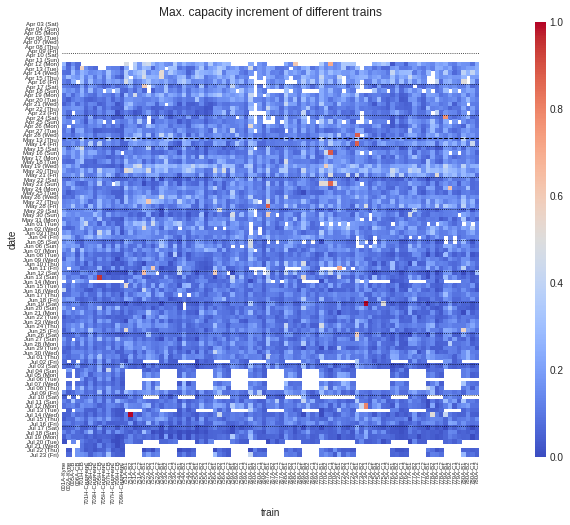

In [34]:
max_step_ = max_step.copy()
max_step_.index = max_step_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(max_step_, ax=ax, center=0.5, square=True,
            xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, max_step_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Max. capacity increment of different trains')

plt.savefig(figures_dir / 'max_capacity_increment.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [35]:
max_step_melt = max_step.reset_index()\
    .melt(id_vars='date', var_name='train', value_name='max_step')

max_step_melt.head(2)

,date,train,max_step
0,2021-04-03,001А-Купе,NaN
1,2021-04-04,001А-Купе,NaN


In [36]:
to_remove = max_step_melt.loc[max_step_melt['max_step'] >= 0.45, ['train', 'date']]\
    .groupby('train')['date'].apply(lambda s: s.unique())

to_remove.head(2)

train
701Н-СВ    [2021-04-13T00:00:00.000000000, 2021-05-15T00:...
705Н-СВ    [2021-06-03T00:00:00.000000000, 2021-06-13T00:...
Name: date, dtype: object

In [37]:
for train, dates_to_remove in tqdm(to_remove.iteritems(), total=len(to_remove)):
    mask = ((data['train'] == train) & data['date'].isin(dates_to_remove))
    data = data[~mask].copy()

data['train'].nunique()

  0%|          | 0/34 [00:00<?, ?it/s]

94

/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/_backend_pdf_ps.py:102: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib

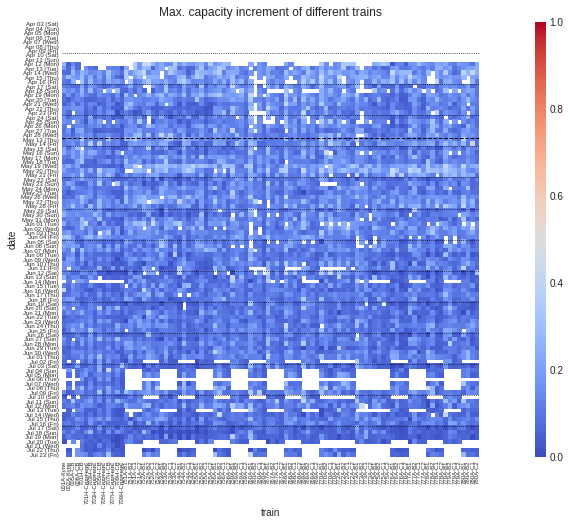

In [38]:
max_step_ = {}

for train in data['train'].unique():
    places_frac = data[data['train'] == train].pivot(index='date', columns='days', values='places_frac')
    max_step_[train] = (places_frac - places_frac.shift(axis=1)).abs().max(axis=1)
    
max_step_ = pd.DataFrame(max_step_).reindex(dates)

max_step_.index = max_step_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(max_step_, ax=ax, vmin=0, vmax=1, square=True,
            xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, max_step_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Max. capacity increment of different trains')

plt.savefig(figures_dir / 'max_capacity_increment_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [39]:
trains = sorted(data['train'].unique().tolist())

len(trains)

94

In [40]:
ncols = 9
nrows = len(trains) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
for i in range(1, nrows, 3):
    axes[(i + 1) * ncols - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(len(trains), len(axes)):
    axes[i].axis('off')
    
plt.savefig(figures_dir / 'places_vs_weekday_.pdf', transparent=True, bbox_inches='tight')
plt.close()

No handles with labels found to put in legend.
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/_backend_pdf_ps.py:102: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/mnt/ess_storage/DL_0/lake/ylytkin/miniconda3/envs/globalvenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 774 missing from current font.
  font.set_text(s, 0, flags=flags)


### Заполняем пропуски (по средним значениям)

In [43]:
for train in tqdm(trains):
    train_data = data[(data['train'] == train)].pivot(index='date', columns='days', values='places')
    
    x_filled = impute_average(
        train_data.values,
        low=train_data.min().min(),
        high=train_data.max().max(),
        period=10,
    )
    
    filled_data = pd.DataFrame(
        x_filled,
        index=train_data.index,
        columns=train_data.columns,
    )
    
    break
    
    


  0%|          | 0/94 [00:00<?, ?it/s]

<AxesSubplot:xlabel='days'>

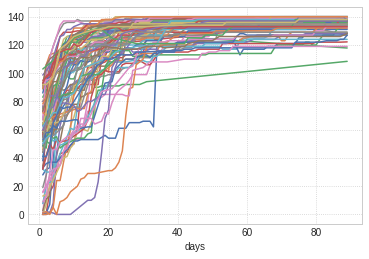

In [44]:
filled_data.T.plot(legend=False)

In [45]:
train_data.values = impute_average(train_data.values)

<ipython-input-45-5d20fda26d59>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  train_data.values = impute_average(train_data.values)


AttributeError: can't set attribute

days,1,2,3,4,5,6,7,8,9,10,...,80,81,82,83,84,85,86,87,88,89
date,,,,,,,,,,,,,,,,,,,,,
2021-04-12,28.0,32.0,33.0,72.0,85.0,99.0,103.0,105.0,109.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-13,52.0,55.0,56.0,56.0,83.0,91.0,103.0,105.0,106.0,106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-14,91.0,103.0,106.0,107.0,108.0,115.0,119.0,126.0,NaN,127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-15,73.0,93.0,104.0,105.0,107.0,107.0,111.0,113.0,114.0,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-16,48.0,64.0,73.0,82.0,91.0,96.0,96.0,104.0,113.0,120.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-16,NaN,65.0,75.0,76.0,NaN,90.0,104.0,105.0,107.0,107.0,...,137.0,137.0,137.0,137.0,NaN,NaN,137.0,NaN,137.0,137.0
2021-07-17,73.0,NaN,89.0,94.0,94.0,NaN,108.0,110.0,111.0,110.0,...,126.0,126.0,126.0,126.0,126.0,126.0,126.0,126.0,NaN,128.0
2021-07-18,NaN,13.0,NaN,46.0,46.0,51.0,NaN,55.0,56.0,NaN,...,NaN,119.0,NaN,119.0,119.0,NaN,119.0,119.0,119.0,NaN


### Выбросы по значениям ГК

Строим модель PCA, смотрим на её выбросы.

_Замечание._ Да, непосредственно значения ГК на данных с выбросами анализировать некорректно, но хотя бы пики можно по ним отслеживать.

In [ ]:
maxdays = 60

In [ ]:
models = {}
metrics = []

for train in tqdm(trains):
    train_data = data[(data['train'] == train) & (data['days'] <= maxdays)]

    places = train_data.pivot(index='date', columns='days', values='places_frac')
    prices = train_data.pivot(index='date', columns='days', values='price')
    
    model = PlacePriceModel(maxiter=10000, tol=1e-4)
    
    try:
        model.fit(places, prices)
        models[train] = model
        
        train_num, train_class = train.split('-')
        metrics.append((train_num, train_class, model.explained_variance, model.r2))
        
    except Exception as e:
        print(train, e)
    
metrics = pd.DataFrame(metrics, columns=['num', 'class', 'explained', 'r2'])
metrics['train'] = metrics['num'] + '-' + metrics['class']

metrics.to_csv(results_dir / 'model_metrics.csv', index=False)

metrics.head(2)

In [ ]:
metrics.plot(kind='scatter', x='explained', y='r2')

In [ ]:
a = pd.DataFrame({train: model.a for train, model in models.items()})

a.reset_index().to_csv(results_dir / 'principal_components.csv', index=False)

a.head(2)

In [ ]:
a_ = a.copy().reindex(dates)
a_.index = a_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(a_, ax=ax, center=0, square=True,
            xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, a_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Principal components of different trains')

plt.savefig(figures_dir / 'pcs.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [ ]:
a_melt = a.fillna(-5).reset_index().melt(id_vars='date', var_name='train', value_name='pc')

a_melt.head(2)

In [ ]:
thres = -3

In [ ]:
to_remove = a_melt.loc[a_melt['pc'] < thres, ['train', 'date']]\
    .groupby('train')['date'].apply(lambda s: s.unique())

to_remove.head(2)

In [ ]:
for train, dates_to_remove in tqdm(to_remove.iteritems(), total=len(to_remove)):
    mask = ((data['train'] == train) & data['date'].isin(dates_to_remove))
    data = data[~mask].copy()

data['train'].nunique()

In [ ]:
a_ = a_melt.pivot(index='date', columns='train', values='pc').reindex(dates)
a_.values[a_.values < thres] = np.nan
a_.index = a_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(a_, ax=ax, center=0, vmin=a.min().min(), square=True,
            xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, a_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Principal components of different trains')

plt.savefig(figures_dir / 'pcs_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

Ручным образом удаляем малочисленные "нижние" выбросы.

In [ ]:
ncols = 9
nrows = len(trains) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
for i in range(1, nrows, 3):
    axes[(i + 1) * ncols - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(len(trains), len(axes)):
    axes[i].axis('off')
    
plt.savefig(figures_dir / 'places_vs_weekday_clean.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [ ]:
filled_frac = pd.DataFrame({
    train: data[(data['train'] == train) & (data['days'] <= 30)]\
                    .pivot(index='date', columns='days', values='places')\
                    .notna().mean(axis=1)
    for train in sorted(data['train'].unique())
}).reindex(dates).fillna(0)
filled_frac.index = filled_frac.index.map(date_formatter)

ax = plt.figure(figsize=(22, 9)).gca()
sns.heatmap(filled_frac, center=0.5, square=True, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Fraction of filled values for different trains\n'
             '(30-day lag)')

plt.savefig(figures_dir / 'filled_frac_final.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [ ]:
filled_frac = pd.DataFrame({
    train: data[(data['train'] == train) & (data['days'] <= 60)]\
                    .pivot(index='date', columns='days', values='places')\
                    .notna().mean(axis=1)
    for train in sorted(data['train'].unique())
}).reindex(dates).fillna(0)
filled_frac.index = filled_frac.index.map(date_formatter)

ax = plt.figure(figsize=(22, 9)).gca()
sns.heatmap(filled_frac, center=0.5, square=True, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Fraction of filled values for different trains\n'
             '(60-day lag)')

plt.savefig(figures_dir / 'filled_frac_60day_final.pdf', transparent=True, bbox_inches='tight')
# plt.close()

***

In [ ]:
data.drop(columns=['weekday', 'day_name']).to_csv('../data/data.csv', index=False, encoding='utf-8')

In [ ]:
!jupyter nbconvert --to html preprocessing.ipynb